In [1]:
import pandas as pd

df = pd.read_csv("Dataset.csv", engine='python', on_bad_lines='skip')
print(df.head())
print(df.shape)

   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN  ...   
3           3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN  ...   
4           4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02       3   
3         NaN        NaN  68.54       0    NaN    NaN        -0.02       4   
4         NaN      330.0  68.54       0    NaN    NaN        -0.02       5   

   SepsisLabel  Patient_ID  
0            0       17072 

In [2]:
import pandas as pd
import numpy as np

# Inspect basic info
df = df.copy()
print(df.shape)
print(df.head())

(1552210, 44)
   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN  ...   
3           3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN  ...   
4           4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02       3   
3         NaN        NaN  68.54       0    NaN    NaN        -0.02       4   
4         NaN      330.0  68.54       0    NaN    NaN        -0.02       5   

   SepsisLabel  Patient_ID  
0            

In [3]:
# Drop index-like and empty columns
drop_cols = ['Unnamed: 0', 'EtCO2', 'Unit1', 'Unit2']
df.drop(columns=drop_cols, inplace=True, errors='ignore')
print(df.columns)

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS',
       'SepsisLabel', 'Patient_ID'],
      dtype='object')


In [4]:
vital_cols = [
    'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
    'Resp', 'Platelets', 'Age'
]
label_col = 'SepsisLabel'
id_col = 'Patient_ID'

df = df[[id_col] + vital_cols + [label_col]]
print(df.head())

   Patient_ID    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  Platelets    Age  \
0       17072   NaN    NaN   NaN    NaN   NaN   NaN   NaN        NaN  68.54   
1       17072  65.0  100.0   NaN    NaN  72.0   NaN  16.5        NaN  68.54   
2       17072  78.0  100.0   NaN    NaN  42.5   NaN   NaN        NaN  68.54   
3       17072  73.0  100.0   NaN    NaN   NaN   NaN  17.0        NaN  68.54   
4       17072  70.0  100.0   NaN  129.0  74.0  69.0  14.0      330.0  68.54   

   SepsisLabel  
0            0  
1            0  
2            0  
3            0  
4            0  


In [5]:
# Forward-fill within each patient, then global median fill
df[vital_cols] = df[vital_cols].apply(pd.to_numeric, errors='coerce')
df[vital_cols] = (
    df.groupby(id_col)[vital_cols]
    .ffill()
    .bfill()
)
df[vital_cols] = df[vital_cols].fillna(df[vital_cols].median())
print(df.isna().sum())

Patient_ID     0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
Platelets      0
Age            0
SepsisLabel    0
dtype: int64


In [6]:
patient_labels = (
    df.groupby(id_col)[label_col]
    .max()
    .reset_index()
)
print(patient_labels[label_col].value_counts(normalize=True))

SepsisLabel
0    0.927311
1    0.072689
Name: proportion, dtype: float64


In [7]:
agg_features = {}
for col in vital_cols:
    agg_features[col + '_mean'] = (col, 'mean')
    agg_features[col + '_max'] = (col, 'max')
    agg_features[col + '_min'] = (col, 'min')
    agg_features[col + '_last'] = (col, lambda x: x.iloc[-1])

patient_features = (
    df.groupby(id_col)
    .agg(**agg_features)
    .reset_index()
)
print(patient_features.head())

   Patient_ID     HR_mean  HR_max  HR_min  HR_last  O2Sat_mean  O2Sat_max  \
0           1  102.055556   117.0    76.0     84.0   91.398148      100.0   
1           2   60.956522    94.0    54.0     55.0   97.086957      100.0   
2           3   79.927083    93.0    68.0     78.0   95.333333       99.0   
3           4  102.672414   113.0    93.0    108.0   98.155172      100.0   
4           5   76.604167    88.0    61.0     80.0   97.677083       99.0   

   O2Sat_min  O2Sat_last  Temp_mean  ...  Resp_min  Resp_last  Platelets_mean  \
0       85.0        85.0  36.636296  ...      17.0       18.0      322.833333   
1       94.0        95.0  36.181739  ...       9.0       11.0      158.000000   
2       91.0        97.0  37.469583  ...      17.0       26.0      476.354167   
3       95.5        98.0  36.447931  ...      14.0       19.0      170.206897   
4       96.0        97.0  37.072292  ...      14.0       16.0      276.562500   

   Platelets_max  Platelets_min  Platelets_last  A

In [8]:
data = patient_features.merge(patient_labels, on=id_col)
print(data.shape)
print(data.head())

(40336, 38)
   Patient_ID     HR_mean  HR_max  HR_min  HR_last  O2Sat_mean  O2Sat_max  \
0           1  102.055556   117.0    76.0     84.0   91.398148      100.0   
1           2   60.956522    94.0    54.0     55.0   97.086957      100.0   
2           3   79.927083    93.0    68.0     78.0   95.333333       99.0   
3           4  102.672414   113.0    93.0    108.0   98.155172      100.0   
4           5   76.604167    88.0    61.0     80.0   97.677083       99.0   

   O2Sat_min  O2Sat_last  Temp_mean  ...  Resp_last  Platelets_mean  \
0       85.0        85.0  36.636296  ...       18.0      322.833333   
1       94.0        95.0  36.181739  ...       11.0      158.000000   
2       91.0        97.0  37.469583  ...       26.0      476.354167   
3       95.5        98.0  36.447931  ...       19.0      170.206897   
4       96.0        97.0  37.072292  ...       16.0      276.562500   

   Platelets_max  Platelets_min  Platelets_last  Age_mean  Age_max  Age_min  \
0          338.0   

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=[id_col, label_col])
y = data[label_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(y_train.value_counts(normalize=True))

SepsisLabel
0    0.927296
1    0.072704
Name: proportion, dtype: float64


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)
lr.fit(X_train, y_train)
print(lr)

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)


c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.83      7482
           1       0.15      0.64      0.25       586

    accuracy                           0.72      8068
   macro avg       0.56      0.68      0.54      8068
weighted avg       0.90      0.72      0.78      8068

ROC-AUC: 0.73285646644096
Confusion Matrix:
 [[5406 2076]
 [ 210  376]]


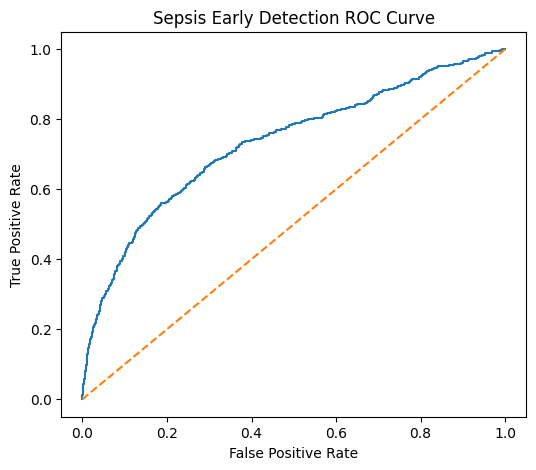

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Sepsis Early Detection ROC Curve")
plt.show()

In [13]:
def risk_level(p):
    if p < 0.3:
        return "Low Risk"
    elif p < 0.6:
        return "Medium Risk"
    else:
        return "High Risk"

In [14]:
risk_df = pd.DataFrame({
    "Sepsis_Probability": y_prob
})
risk_df["Risk_Level"] = risk_df["Sepsis_Probability"].apply(risk_level)
print(risk_df["Risk_Level"].value_counts())

Risk_Level
Medium Risk    4292
Low Risk       2410
High Risk      1366
Name: count, dtype: int64


In [15]:
new_patient = pd.DataFrame({
    'Patient_ID': [999] * 6,
    'HR': [88, 90, 92, 95, 98, 102],
    'O2Sat': [97, 96, 95, 94, 93, 92],
    'Temp': [37.0, 37.2, 37.4, 37.6, 38.0, 38.4],
    'SBP': [120, 118, 115, 112, 108, 105],
    'MAP': [85, 82, 80, 78, 75, 72],
    'DBP': [75, 73, 70, 68, 65, 62],
    'Resp': [18, 19, 20, 22, 24, 26],
    'Platelets': [250, 245, 240, 230, 220, 210],
    'Age': [65] * 6
})

In [16]:
agg = {}
for col in vital_cols:
    agg[col + '_mean'] = (col, 'mean')
    agg[col + '_max'] = (col, 'max')
    agg[col + '_min'] = (col, 'min')
    agg[col + '_last'] = (col, lambda x: x.iloc[-1])

new_features = (
    new_patient
    .groupby('Patient_ID')
    .agg(**agg)
    .reset_index()
)
X_new = new_features.drop(columns=['Patient_ID'])

In [17]:
new_prob = lr.predict_proba(X_new)[0][1]
print("Sepsis Risk Probability:", round(new_prob, 3))
print("Risk Level:", risk_level(new_prob))

Sepsis Risk Probability: 0.779
Risk Level: High Risk


In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print(rf_model)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)


In [19]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("RandomForestClassifier Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

RandomForestClassifier Performance:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7482
           1       0.75      0.02      0.03       586

    accuracy                           0.93      8068
   macro avg       0.84      0.51      0.50      8068
weighted avg       0.92      0.93      0.89      8068

ROC-AUC: 0.816240091121992
Confusion Matrix:
 [[7479    3]
 [ 577    9]]


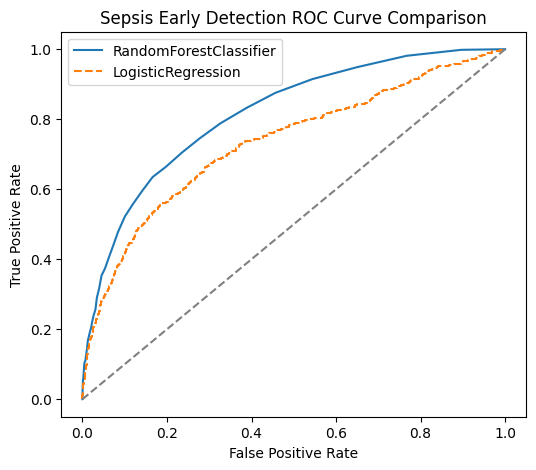

In [20]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate ROC curve for RandomForestClassifier
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Calculate ROC curve for Logistic Regression
y_prob_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rf, tpr_rf, label='RandomForestClassifier')
plt.plot(fpr_lr, tpr_lr, label='LogisticRegression', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Sepsis Early Detection ROC Curve Comparison")
plt.legend()
plt.show()

In [21]:
new_prob_rf = rf_model.predict_proba(X_new)[0][1]
print("RandomForestClassifier Sepsis Risk Probability (New Patient):", round(new_prob_rf, 3))
print("RandomForestClassifier Risk Level (New Patient):", risk_level(new_prob_rf))

RandomForestClassifier Sepsis Risk Probability (New Patient): 0.2
RandomForestClassifier Risk Level (New Patient): Low Risk
